In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
obesity = pd.read_csv("/content/drive/MyDrive/obesity-prevalence-adults-who-gho.csv")
calories = pd.read_csv("/content/drive/MyDrive/daily-per-capita-caloric-supply.csv")
macros = pd.read_csv("/content/drive/MyDrive/daily-caloric-supply-derived-from-carbohydrates-protein-and-fat.csv")

In [ ]:
obesity.head(5), calories.head(5), macros.head(5)

(        Entity Code  Year  \
 0  Afghanistan  AFG  1990   
 1  Afghanistan  AFG  1991   
 2  Afghanistan  AFG  1992   
 3  Afghanistan  AFG  1993   
 4  Afghanistan  AFG  1994   
 
    Prevalence of obesity among adults, BMI >= 30 (age-standardized estimate) (%) - Sex: both sexes - Age group: 18+  years of age  
 0                                            1.94951                                                                               
 1                                            2.10504                                                                               
 2                                            2.27339                                                                               
 3                                            2.45549                                                                               
 4                                            2.65288                                                                               ,
         Entity Cod

In [ ]:
# Making every dataset span from 1990 to 2022
obesity = obesity[obesity['Year'] >= 1990]
calories = calories[calories['Year'] >= 1990]
macros = macros[macros['Year'] >= 1990]

In [ ]:
# Renaming column names to make them more understandable
obesity_df = obesity.rename(columns={
    "Entity": "Country",
    "Year": "Year",
    "Prevalence of obesity among adults, BMI >= 30 (age-standardized estimate) (%) - Sex: both sexes - Age group: 18+  years of age": "ObesityRate"
})

calories_df = calories.rename(columns={
    "Entity": "Country",
    "Year": "Year",
    "Daily calorie supply per person": "CaloriesPerDay"
})

macros_df = macros.rename(columns={
    "Entity": "Country",
    "Year": "Year",
    "Daily calorie supply per person from carbohydrates": "Carbs",
    "Daily calorie supply per person that comes from animal protein": "AnimalProtein",
    "Daily calorie supply per person that comes from vegetal protein": "VegetableProtein",
    "Daily calorie supply per person from fat": "Fat"
})


# Resetting the indices
obesity_df = obesity_df.reset_index(drop=True)
calories_df = calories_df.reset_index(drop=True)
macros_df = macros_df.reset_index(drop=True)

print(len(obesity_df),len(calories_df),len(macros_df))


6798 7191 7191


---

# **Data Preprocessing**

---

In [ ]:
# Checking for missing values
print("=== MISSING VALUES CHECK ===")
print("Obesity_df missing values:")
print(obesity_df.isnull().sum())
print("\nCalories_df missing values:")
print(calories_df.isnull().sum())
print("\nMacros_df missing values:")
print(macros_df.isnull().sum())

=== MISSING VALUES CHECK ===
Obesity_df missing values:
Country          0
Code           198
Year             0
ObesityRate      0
dtype: int64

Calories_df missing values:
Country              0
Code              1383
Year                 0
CaloriesPerDay       0
dtype: int64

Macros_df missing values:
Country                0
Code                1383
Year                   0
AnimalProtein          0
VegetableProtein       0
Fat                    0
Carbs                  0
dtype: int64


In [ ]:
# Remove regions with missing codes using dropna
obesity_df = obesity_df.dropna(subset=['Code'])
calories_df = calories_df.dropna(subset=['Code'])
macros_df = macros_df.dropna(subset=['Code'])
# Now we only have countries left in our dataset. Removed regions like Africa,Low Income Countries etc.

In [ ]:
print(obesity_df['Country'].nunique(),calories_df['Country'].nunique(),macros_df['Country'].nunique())

200 198 198


In [ ]:
# We get the countries which are common in all 3 datasets
common_countries = set(obesity_df['Country']).intersection(set(calories_df['Country']),set(macros_df['Country']))
obesity_final = obesity_df[obesity_df['Country'].isin(common_countries)]
calories_final = calories_df[calories_df['Country'].isin(common_countries)]
macros_final = macros_df[macros_df['Country'].isin(common_countries)]

In [ ]:
print(obesity_final['Country'].nunique(),calories_final['Country'].nunique(),macros_final['Country'].nunique())

188 188 188


In [ ]:
# Checking for duplicates
print(f"Obesity_df duplicates: {obesity_final.duplicated().sum()}")
print(f"Calories_df duplicates: {calories_final.duplicated().sum()}")
print(f"Macros_df duplicates: {macros_final.duplicated().sum()}")

Obesity_df duplicates: 0
Calories_df duplicates: 0
Macros_df duplicates: 0


In [ ]:
# Checking if data is consistent throughout all the 3 datsets
print("Unique countries in each dataset:")
print(f"Obesity_df: {obesity_final['Country'].nunique()} countries")
print(f"Calories_df: {calories_final['Country'].nunique()} countries")
print(f"Macros_df: {macros_final['Country'].nunique()} countries")

print(f"\nCommon years across datasets:")
print(f"Obesity years: {obesity_final['Year'].nunique()}")
print(f"Calories years: {calories_final['Year'].nunique()}")
print(f"Macros years: {macros_final['Year'].nunique()}")

Unique countries in each dataset:
Obesity_df: 188 countries
Calories_df: 188 countries
Macros_df: 188 countries

Common years across datasets:
Obesity years: 33
Calories years: 33
Macros years: 33


In [ ]:
obesity_final.shape,calories_final.shape,macros_final.shape

# We have some countries which do not have data for all years i.e. 1990-2022
# So let's keep countries that have data for

((6204, 4), (5632, 4), (5632, 7))

In [ ]:
# We have 141 countries that have all 33 years of data which is more than enough, so we are going to remove all other countries with missing years.
complete_countries = calories_final.groupby('Country').filter(lambda x: len(x) == 33)['Country'].unique()
print(len(complete_countries))

141


In [ ]:
obesity_final = obesity_final[obesity_final['Country'].isin(complete_countries)]
calories_final = calories_final[calories_final['Country'].isin(complete_countries)]
macros_final = macros_final[macros_final['Country'].isin(complete_countries)]

print(obesity_final.shape,calories_final.shape,macros_final.shape)

(4653, 4) (4653, 4) (4653, 7)




---

# **Merging the Datasets**

---

In [ ]:
nutrition_df = calories_final.merge(macros_final, on=['Country', 'Code', 'Year'])
final_df = obesity_final.merge(nutrition_df, on=['Country', 'Code', 'Year'])

print("=== MERGED DATASET ===")
print(f"Final shape: {final_df.shape}")
print(f"Columns: {list(final_df.columns)}")
print(f"Time range: {final_df['Year'].min()} - {final_df['Year'].max()}")
print(f"Countries: {final_df['Country'].nunique()}")

=== MERGED DATASET ===
Final shape: (4653, 9)
Columns: ['Country', 'Code', 'Year', 'ObesityRate', 'CaloriesPerDay', 'AnimalProtein', 'VegetableProtein', 'Fat', 'Carbs']
Time range: 1990 - 2022
Countries: 141


---

# **Visualisations and Inferences**

---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### *1. Global Average Obesity Across the Years (1990-2022)*

In [ ]:
global_trend = final_df.groupby('Year')['ObesityRate'].mean().reset_index()

print("Global average obesity rates by year:")
print(global_trend.head(5))

Global average obesity rates by year:
   Year  ObesityRate
0  1990     9.001602
1  1991     9.312141
2  1992     9.634437
3  1993     9.969566
4  1994    10.319816


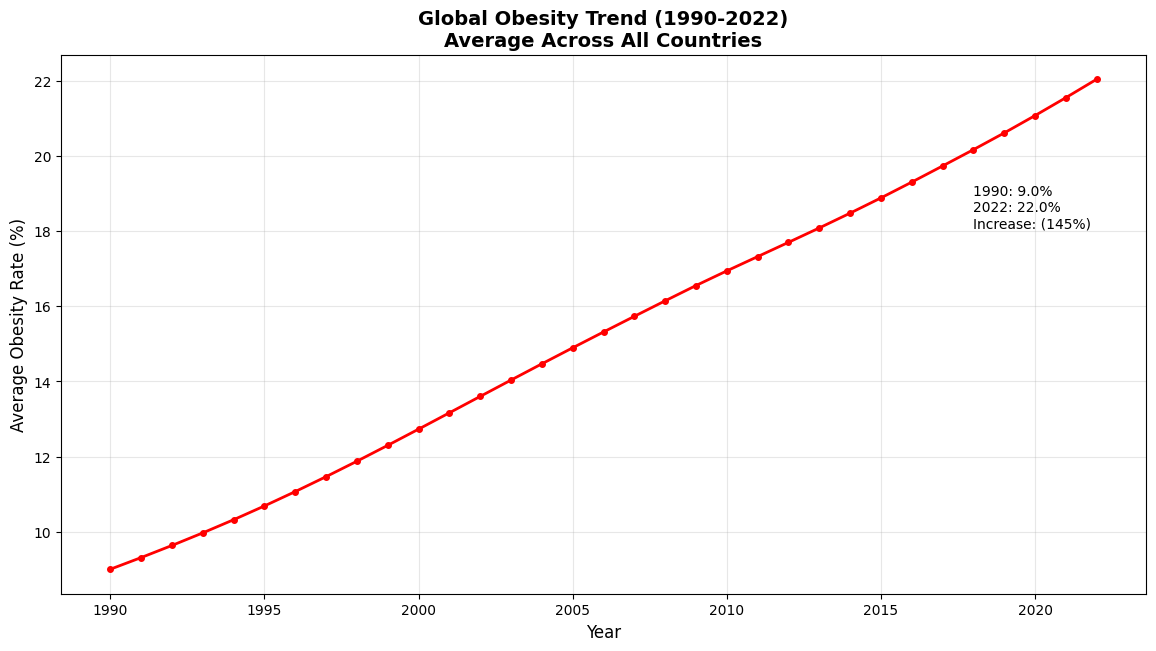

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(global_trend['Year'], global_trend['ObesityRate'],
         marker='o', linewidth=2, markersize=4, color='red')

plt.title('Global Obesity Trend (1990-2022)\nAverage Across All Countries',
          fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Obesity Rate (%)', fontsize=12)

plt.grid(True, alpha=0.3)

first_year = global_trend.iloc[0]
last_year = global_trend.iloc[-1]
increase = last_year['ObesityRate'] - first_year['ObesityRate']
increase_percent = (increase / first_year['ObesityRate']) * 100

plt.annotate(f'1990: {first_year["ObesityRate"]:.1f}%\n2022: {last_year["ObesityRate"]:.1f}%\nIncrease: ({increase_percent:.0f}%)',
             xy=(2018, global_trend.iloc[-10]['ObesityRate']))

plt.show()


### *2. MacroNutrient Analysis*

In [ ]:
final_df['Protein_Percent'] = (final_df['AnimalProtein'] + final_df['VegetableProtein']) / final_df['CaloriesPerDay'] * 100
final_df['Fat_Percent'] = final_df['Fat'] / final_df['CaloriesPerDay'] * 100
final_df['Carbs_Percent'] = final_df['Carbs'] / final_df['CaloriesPerDay'] * 100

print(f"Average diet: {final_df['Protein_Percent'].mean():.1f}% Protein, " +
      f"{final_df['Fat_Percent'].mean():.1f}% Fat, " +
      f"{final_df['Carbs_Percent'].mean():.1f}% Carbs")

Average diet: 11.2% Protein, 25.7% Fat, 63.1% Carbs


In [ ]:
correlation_protein = final_df['Protein_Percent'].corr(final_df['ObesityRate']).round(3)
correlation_fat = final_df['Fat_Percent'].corr(final_df['ObesityRate']).round(3)
correlation_carbs = final_df['Carbs_Percent'].corr(final_df['ObesityRate']).round(3)
correlation_calories = final_df['CaloriesPerDay'].corr(final_df['ObesityRate']).round(3)

print("Correlation with Obesity Rate:")
print(f"Protein: {correlation_protein}")
print(f"Fat: {correlation_fat}")
print(f"Carbs: {correlation_carbs}")
print(f"Total Calories: {correlation_calories}")

Correlation with Obesity Rate:
Protein: 0.404
Fat: 0.509
Carbs: -0.527
Total Calories: 0.501


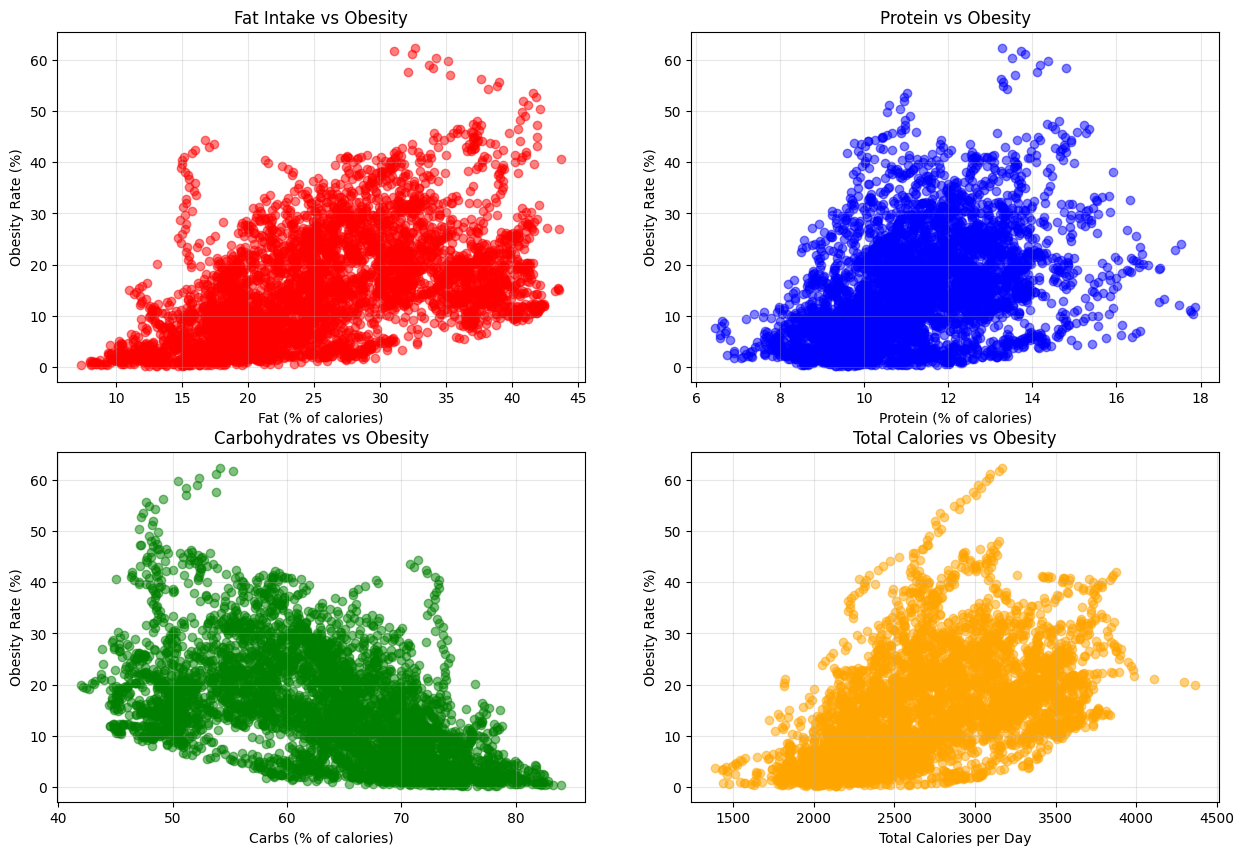

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(final_df['Fat_Percent'], final_df['ObesityRate'], alpha=0.5, color='red')
plt.xlabel('Fat (% of calories)')
plt.ylabel('Obesity Rate (%)')
plt.title('Fat Intake vs Obesity')
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 2)
plt.scatter(final_df['Protein_Percent'], final_df['ObesityRate'], alpha=0.5, color='blue')
plt.xlabel('Protein (% of calories)')
plt.ylabel('Obesity Rate (%)')
plt.title('Protein vs Obesity')
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 3)
plt.scatter(final_df['Carbs_Percent'], final_df['ObesityRate'], alpha=0.5, color='green')
plt.xlabel('Carbs (% of calories)')
plt.ylabel('Obesity Rate (%)')
plt.title('Carbohydrates vs Obesity')
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 4)
plt.scatter(final_df['CaloriesPerDay'], final_df['ObesityRate'], alpha=0.5, color='orange')
plt.xlabel('Total Calories per Day')
plt.ylabel('Obesity Rate (%)')
plt.title('Total Calories vs Obesity')
plt.grid(True, alpha=0.3)

plt.show()

### *3. Obesity Changes By Country (1990 vs 2022)*

In [ ]:
obesity_1990 = final_df[final_df['Year'] == 1990][['Country', 'ObesityRate']]
obesity_2022 = final_df[final_df['Year'] == 2022][['Country', 'ObesityRate']]

obesity_comparison = obesity_1990.merge(obesity_2022, on='Country',suffixes=('_1990', '_2022'))
obesity_comparison['Change'] = obesity_comparison['ObesityRate_2022'] - obesity_comparison['ObesityRate_1990']

top_5_increases = obesity_comparison.nlargest(5, 'Change')
bottom_5_decreases = obesity_comparison.nsmallest(5, 'Change')

selected_countries = pd.concat([top_5_increases, bottom_5_decreases])

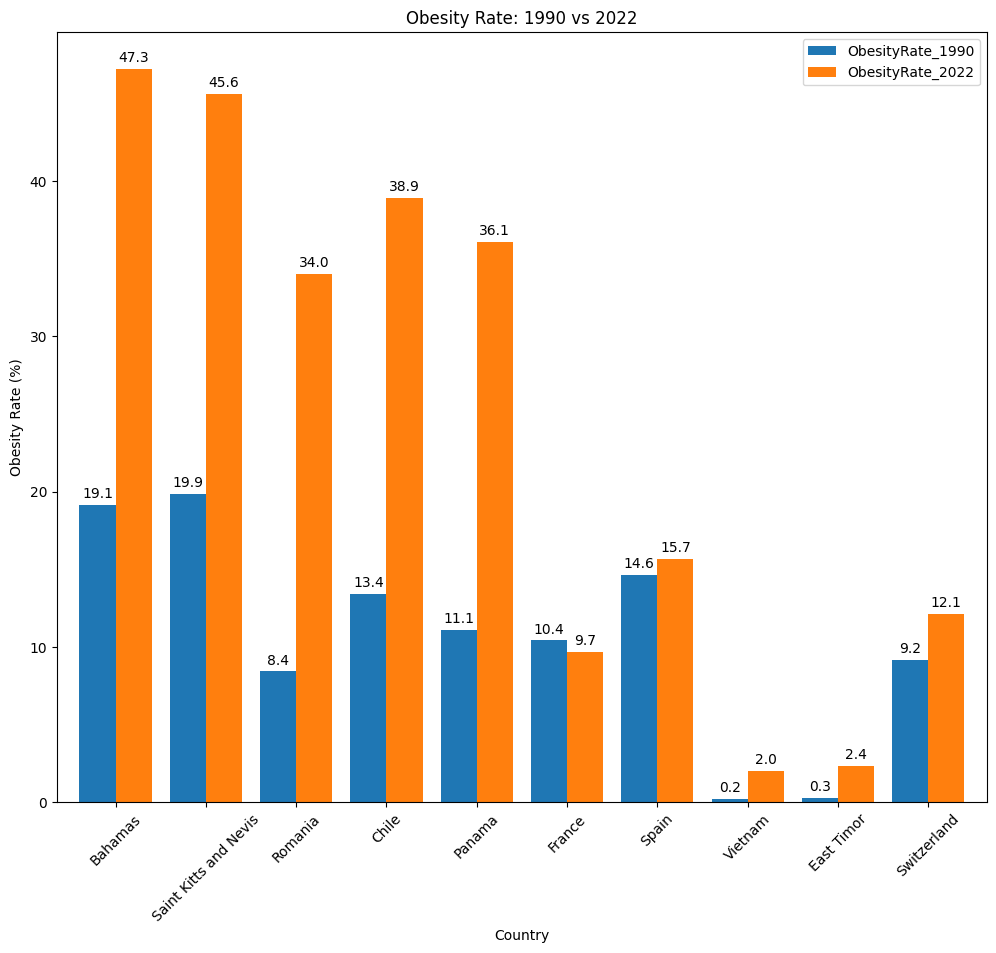

In [ ]:
ax = selected_countries.plot(x='Country', y=['ObesityRate_1990', 'ObesityRate_2022'],kind='bar',
                             figsize=(12, 10), width=0.8)
plt.title('Obesity Rate: 1990 vs 2022')
plt.ylabel('Obesity Rate (%)')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.show()

---

# **Descriptive And Predictive Analysis**

---

## *1. Clustering (Descriptive)*

In [ ]:
ml_data = final_df[final_df['Year'] == 2022].copy()

features = ['Fat_Percent', 'Carbs_Percent', 'Protein_Percent', 'CaloriesPerDay']
X = ml_data[features]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2,8):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_scaled)
  inertia.append(kmeans.inertia_)
  print(k, f"{inertia[k-2]:.2f}")

2 242.34
3 191.25
4 160.23
5 145.32
6 123.85
7 104.65


K=2 → K=3: Improvement = 51.1 (21.1%)
K=3 → K=4: Improvement = 31.0 (16.2%)
K=4 → K=5: Improvement = 14.9 (9.3%)
K=5 → K=6: Improvement = 21.5 (14.8%)
K=6 → K=7: Improvement = 19.2 (15.5%)


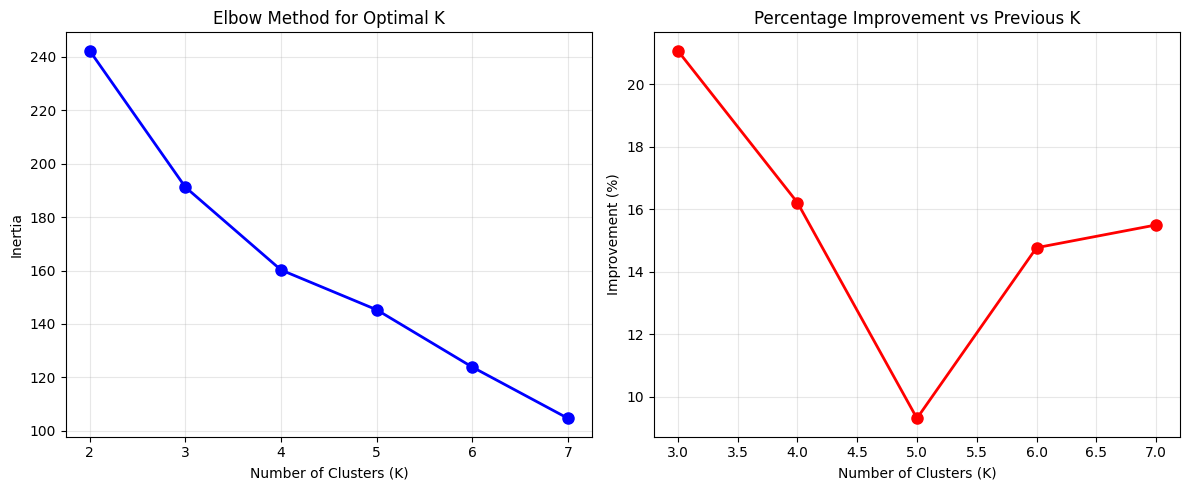

In [ ]:
k_values = [2, 3, 4, 5, 6, 7]

improvements = []
for i in range(1, len(inertia)):
    improvement = inertia[i-1] - inertia[i]
    percent_improvement = (improvement / inertia[i-1]) * 100
    improvements.append(percent_improvement)
    print(f"K={k_values[i-1]} → K={k_values[i]}: Improvement = {improvement:.1f} ({percent_improvement:.1f}%)")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values[1:], improvements, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Improvement (%)')
plt.title('Percentage Improvement vs Previous K')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

ml_data['Cluster'] = clusters

In [ ]:
cluster_stats = ml_data.groupby('Cluster').agg({
    'Fat_Percent': 'mean',
    'Carbs_Percent': 'mean',
    'Protein_Percent': 'mean',
    'CaloriesPerDay': 'mean',
    'ObesityRate': 'mean',
    'Country': 'count'
}).round(1)

cluster_stats = cluster_stats.rename(columns={'Country': 'Number_of_Countries'})
print("Average values for each cluster:")
print(cluster_stats)

Average values for each cluster:
         Fat_Percent  Carbs_Percent  Protein_Percent  CaloriesPerDay  \
Cluster                                                                
0               18.4           72.0              9.6          2412.4   
1               35.9           50.6             13.5          3345.4   
2               22.2           66.1             11.7          2920.7   
3               31.4           57.0             11.6          2771.6   

         ObesityRate  Number_of_Countries  
Cluster                                    
0               12.9                   36  
1               27.4                   48  
2               20.8                   34  
3               27.1                   23  


#### **CLUSTER 0: LOW-FAT, HIGH-CARB TRADITIONAL DIETS**
- DIET PROFILE: Grain-based diets, limited fat sources, staple foods
- OBESITY: Lowest obesity rates (12.9%)
- CALORIES: Lowest calorie intake (2412 kcal)
- TYPICAL COUNTRIES: Afghanistan, Angola, Bangladesh, Cambodia, Cameroon
- IMPLICATION: Diets dominated by grains, limited animal products and oils

#### **CLUSTER 1: HIGH-FAT WESTERN DIETS**
- DIET PROFILE: Meat-heavy, dairy-rich, processed foods, high in oils
- OBESITY: Highest obesity rates (27.4%)
- CALORIES: Highest calorie intake (3345 kcal)
- TYPICAL COUNTRIES: USA, Australia, Austria, Argentina, Albania
- IMPLICATION: Affluent diets with abundant animal products and processed food

#### **CLUSTER 2: TRANSITIONAL MIXED DIETS**
- DIET PROFILE: Combination of traditional staples with increasing fats
- OBESITY: Moderate obesity rates (20.8%)
- CALORIES: Moderate calorie intake (2921 kcal)
- TYPICAL COUNTRIES: India, Algeria, Benin, Bolivia, Botswana
- IMPLICATION: Countries balancing traditional foods with dietary changes

#### **CLUSTER 3: HIGH-FAT, HIGH-CARB COMBINATION DIETS**
- DIET PROFILE: Both traditional carbs and significant fat sources
- OBESITY: High obesity rates (27.1%)
- CALORIES: Moderate-high calories (2772 kcal)
- TYPICAL COUNTRIES: Chile, Colombia, Belize, Central African Republic
- IMPLICATION: Traditional diets supplemented with oils, meats, or fried foods

---
## *2. Classfication (Predictive)*

In [ ]:
classification_data = ml_data.copy()

features = ['Fat_Percent', 'Carbs_Percent', 'Protein_Percent', 'CaloriesPerDay']
X = classification_data[features]

low_threshold = classification_data['ObesityRate'].quantile(0.33)
high_threshold = classification_data['ObesityRate'].quantile(0.67)

print(f"Low obesity threshold: {low_threshold:.1f}%")
print(f"High obesity threshold: {high_threshold:.1f}%")

def categorize_obesity(rate):
    if rate <= low_threshold:
        return 0
    elif rate <= high_threshold:
        return 1
    else:
        return 2

y = classification_data['ObesityRate'].apply(categorize_obesity)

print(f"\nCategory distribution:")
print(f" Low obesity (0): {(y == 0).sum()} countries")
print(f" Medium obesity (1): {(y == 1).sum()} countries")
print(f" High obesity (2): {(y == 2).sum()} countries")

Low obesity threshold: 14.9%
High obesity threshold: 28.1%

Category distribution:
 Low obesity (0): 47 countries
 Medium obesity (1): 47 countries
 High obesity (2): 47 countries


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_k = 1
best_accuracy = 0

for k in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled,y_train)
  y_pred = knn.predict(X_test_scaled)
  accuracy = accuracy_score(y_test,y_pred)
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_k = k

print(best_k,f"{best_accuracy:.3f}")

8 0.605


In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=8)
knn_final.fit(X_train_scaled, y_train)

y_pred = knn_final.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)


print(f"Test Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Correctly predicted {int(accuracy * len(y_test))} out of {len(y_test)} countries")

Test Accuracy: 0.605 (60.5%)
Correctly predicted 26 out of 43 countries


---
## *3. Regression (Predictive)*

In [ ]:
regression_data = final_df[final_df['Year'] == 2022].copy()

features = ['Fat_Percent', 'Carbs_Percent', 'Protein_Percent', 'CaloriesPerDay']
X = regression_data[features]
y = regression_data['ObesityRate']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape[0]} countries")
print(f"Testing set: {X_test_scaled.shape[0]} countries")
print(f"Training obesity range: {y_train.min():.1f}% to {y_train.max():.1f}%")
print(f"Testing obesity range: {y_test.min():.1f}% to {y_test.max():.1f}%")

Training set: 98 countries
Testing set: 43 countries
Training obesity range: 4.3% to 62.4%
Testing obesity range: 2.0% to 42.3%


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}% (average prediction error)")
print(f"R²: {r2:.3f} (variance explained)")

RMSE: 9.51% (average prediction error)
R²: 0.272 (variance explained)


---

# **Future Plans**

---

### 1. ADD MORE FEATURES:
- Add GDP per capita as a feature"
- Analyze nutrition-obesity relationship by income level"
- Add healthcare, exercise data"

### 2. REGIONAL DEEP DIVES:"
- Compare Western vs Asian vs African patterns"
- Analyze regional clusters within existing clusters"
- Study cultural vs economic influences"

### 3. Clustering With DBSCAN:
- Try clustering with DBSCAN to get better resutls